<a href="https://colab.research.google.com/github/Lipinor/deep_learning_cbpf/blob/master/Final_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Credit Card Fraud Detection

In this notebook we are going to propose a solution to the Credit Card Fraud Dataset from Kaggle (https://www.kaggle.com/mlg-ulb/creditcardfraud). It consists of credit card transactions made in September 2013 by european customers, classified between fraud and non-fraud. The goal is to train a model that is able to indetify fraudulent transactions. The principal feature of this dataset is the imbalance between the classes: less than 0.2% of the dataset consists of fradulent transactions. This brings some challenges to the training that we are going to exploit in this notebook. 

#Setup

Let's begin by importing the necessary libraries:

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Dataset

Here we download the dataset from Kaggle:

In [ ]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


This dataset is composed of credit card transactions made in September 2013 by european customers. The feature 'Time' is the time elapsed between a given transaction and the first one in the dataset (in seconds), 'Amount' is the amount of the transaction, and features 'V1' to 'V28' are numerical input variables whose background is unknown due to confidentiality issues. The classes are 0 (non-fraud, or negative) and 1 (fraud, or positive).

#Exploratory Data Analysis (EDA)

We begin by analyzing how the classes in the dataset are balanced using the np.bincount function from NumPy. 

In [ ]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total, neg, 100 * neg / total, pos, 100 * pos / total))

Examples:
  Total: 284807
  Negative: 284315 (99.83% of total)
  Positive: 492 (0.17% of total)



This dataset is heavily imbalanced: only 0.17% of the transactions are classified as frauds. 

Let's first see how 'Time' and 'Amount', the only features that we know the meaning, are distributed.

In [ ]:
print ("Time - Fraud")
print (raw_df.Time[raw_df.Class == 1].describe())
print ()
print ("Time - Normal")
print (raw_df.Time[raw_df.Class == 0].describe())

Time - Fraud
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64

Time - Normal
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


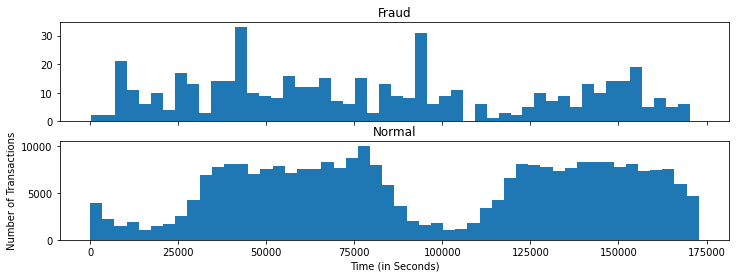

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(raw_df.Time[raw_df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(raw_df.Time[raw_df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

It's not easy to take any conclusion from these distributions, but one can notice that fraudulent transactions contain more peaks in certain time instants, while the legitimate transactions are generally concentrated in certain time periods (maybe we can guess that these periods refer to the commercial time, when most of the customers are shopping). This could make it easier to detect fraud when it takes place outside of these time limits.

In [ ]:
print ("Amount - Fraud")
print (raw_df.Amount[raw_df.Class == 1].describe())
print ()
print ("Amount - Normal")
print (raw_df.Amount[raw_df.Class == 0].describe())

Amount - Fraud
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Amount - Normal
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


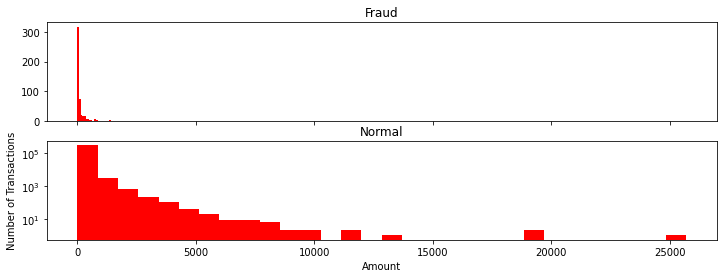

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

ax1.hist(raw_df.Amount[raw_df.Class == 1], color = 'r', bins = bins)
ax1.set_title('Fraud')

ax2.hist(raw_df.Amount[raw_df.Class == 0], color = 'r', bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

It is clearly that fraudulent transactions are in general of small amounts, probably because this kind of transaction is less likely to draw the customer attention. Therefore, this is a very important feature for the model to learn. 

##Data Cleaning

We need to clean the data. First, we are going to check if the dataset contains any null values.

In [ ]:
raw_df.isnull().sum() 

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

This is not the case, so we will not need to perform data engineering in this data set. 

#Splitting and normalizing the data

We need to split the data between a train, validation and test sets. 

* The train data is used to fit the model. 

* The validation data is not used to fit the model, instead we use it to track  how the loss, accuracy and other metrics evolve using data that the model has not seen yet. This set is important to help us notice if the model is overfitting.

* The test data is used at the end of the training to see how the model generalizes to new data.

In [ ]:
# Here we use a utility from sklearn to help us split and shuffle the dataset.
train_df, test_df = train_test_split(raw_df, test_size=0.2)

train_df_features = train_df.copy()
test_df_features = test_df.copy()

# Convert the DataFrame into np arrays of labels and features.
train_df_labels = train_df_features.pop('Class')
test_df_labels = test_df_features.pop('Class')

# Count the negatives and positives
neg_train, pos_train = np.bincount(train_df_labels)
total_train = neg_train + pos_train

neg_test, pos_test = np.bincount(test_df_labels)
total_test = neg_test + pos_test

print('Train:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_train, neg_train, 100 * neg_train / total_train, pos_train, 100 * pos_train / total_train))

print('Test:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_test, neg_test, 100 * neg_test / total_test, pos_test, 100 * pos_test / total_test))

Train:
  Total: 227845
  Negative: 227446 (99.82% of total)
  Positive: 399 (0.18% of total)

Test:
  Total: 56962
  Negative: 56869 (99.84% of total)
  Positive: 93 (0.16% of total)



All 3 sets contains the same percentage of Negative and Positive.

To help during training, we also need to normalize the data, setting its mean to zero and standard deviation to one. 

In [ ]:
scaler = StandardScaler()

train_scaled = StandardScaler().fit_transform(train_df_features.values)

train_df_features = pd.DataFrame(train_scaled, index=train_df_features.index, 
                                 columns=train_df_features.columns)                                        

test_scaled = StandardScaler().fit_transform(test_df_features.values)

test_df_features = pd.DataFrame(test_scaled, index=test_df_features.index, 
                                columns=test_df_features.columns)                       
                                              

print('Training features shape:', train_df_features.shape)
print('Training labels shape:', train_df_labels.shape, "\n")

print('Test features shape:', test_df_features.shape)
print('Test labels shape:', test_df_labels.shape)

Training features shape: (227845, 30)
Training labels shape: (227845,) 

Test features shape: (56962, 30)
Test labels shape: (56962,)


Now all the features have mean equal to 0 and standard deviation equal to 1:

In [ ]:
train_df_features.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05
mean,5.842771e-17,-1.651849e-18,4.946046e-17,-2.680381e-17,2.466908e-17,-3.089981e-17,2.325624e-17,-6.875104e-17,-1.047073e-17,1.556247e-17,3.965169e-19,2.577372e-17,-9.743962e-18,2.940791e-17,-8.111603e-18,-9.796587e-18,8.272159e-18,-1.605997e-17,2.329644e-18,-1.663057e-18,-7.689200e-18,-6.712039e-18,2.056211e-17,-4.959169e-17,-2.170367e-17,-9.985161e-18,-1.104936e-17,-6.113792e-18,8.327221e-18,1.143625e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.997716e+00,-2.869428e+01,-4.397220e+01,-3.180843e+01,-4.009037e+00,-8.182785e+01,-1.957526e+01,-3.491958e+01,-4.309754e+01,-1.222791e+01,-2.257131e+01,-4.703792e+00,-1.871815e+01,-4.025950e+00,-2.007780e+01,-4.907445e+00,-1.611229e+01,-2.965591e+01,-1.105444e+01,-8.529851e+00,-7.043218e+01,-3.125450e+01,-1.309313e+01,-7.163057e+01,-4.681676e+00,-1.979987e+01,-5.401014e+00,-2.442345e+01,-4.628881e+01,-3.526230e-01
25%,-8.551684e-01,-4.675837e-01,-3.611586e-01,-5.859428e-01,-5.993341e-01,-4.979358e-01,-5.759537e-01,-4.448259e-01,-1.768862e-01,-5.848511e-01,-4.911420e-01,-7.462415e-01,-4.074298e-01,-6.510330e-01,-4.454807e-01,-6.368918e-01,-5.342090e-01,-5.700801e-01,-5.944689e-01,-5.609180e-01,-2.724172e-01,-3.110921e-01,-7.477785e-01,-2.584067e-01,-5.851121e-01,-6.094818e-01,-6.775244e-01,-1.740001e-01,-1.589044e-01,-3.299863e-01
50%,-2.135358e-01,9.967292e-03,3.942488e-02,1.187087e-01,-1.343052e-02,-3.850940e-02,-2.065217e-01,3.098879e-02,1.834051e-02,-4.736442e-02,-8.537117e-02,-3.260316e-02,1.396263e-01,-1.371488e-02,5.292841e-02,5.322009e-02,7.490599e-02,-7.786022e-02,-4.220551e-03,4.418013e-03,-7.933618e-02,-3.995390e-02,1.010332e-02,-1.678880e-02,6.706816e-02,3.227135e-02,-1.080802e-01,3.649271e-03,3.348275e-02,-2.647909e-01
75%,9.365297e-01,6.692514e-01,4.867322e-01,6.756655e-01,5.237211e-01,4.411284e-01,2.985711e-01,4.569947e-01,2.762362e-01,5.430929e-01,4.170038e-01,7.242683e-01,6.188236e-01,6.656033e-01,5.166077e-01,7.086953e-01,5.964656e-01,4.716005e-01,5.974799e-01,5.646760e-01,1.732422e-01,2.544484e-01,7.290630e-01,2.365399e-01,7.262310e-01,6.747640e-01,5.004291e-01,2.243599e-01,2.345792e-01,-4.473142e-02
max,1.641150e+00,1.248117e+00,1.333941e+01,2.700374e+00,1.190421e+01,2.503693e+01,5.484897e+01,9.667538e+01,1.692582e+01,9.459661e+00,1.399433e+01,1.178564e+01,4.854674e+00,7.155444e+00,8.103552e+00,9.687266e+00,1.974451e+01,1.090542e+01,5.624062e+00,6.850597e+00,4.926494e+01,3.714627e+01,1.152740e+01,3.530459e+01,7.564669e+00,1.167263e+01,7.083210e+00,7.802698e+01,1.015399e+02,1.022160e+02


In [ ]:
test_df_features.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04
mean,-1.320039e-16,1.257630e-17,-7.078983e-18,-1.729985e-17,-4.129374e-17,-4.391620e-17,4.077432e-17,-1.599398e-17,4.993489e-18,-3.038583e-18,1.621276e-17,4.465684e-17,-5.945312e-17,-1.760195e-17,-1.546578e-17,-1.023296e-17,1.684767e-17,-4.872648e-21,-1.359664e-17,-2.899615e-17,1.068084e-18,1.111743e-17,-1.808836e-17,-9.811563e-18,3.950158e-17,5.786561e-17,1.208417e-18,4.576391e-17,-1.471052e-18,-5.303780e-17
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-1.992074e+00,-1.906818e+01,-3.858305e+01,-2.115170e+01,-3.713282e+00,-3.016205e+01,-1.524369e+01,-2.657830e+01,-5.893445e+01,-8.613275e+00,-2.041491e+01,-4.573745e+00,-1.836967e+01,-5.830911e+00,-1.905989e+01,-4.506061e+00,-1.552919e+01,-2.816818e+01,-1.132805e+01,-8.834286e+00,-3.007637e+01,-4.686819e+01,-1.505085e+01,-5.912839e+01,-4.655589e+00,-1.423642e+01,-5.255816e+00,-5.676864e+01,-3.697746e+01,-3.556798e-01
25%,-8.559793e-01,-4.783269e-01,-3.675900e-01,-5.924995e-01,-5.991010e-01,-5.142726e-01,-5.796205e-01,-4.597831e-01,-1.663328e-01,-5.872818e-01,-4.936891e-01,-7.498083e-01,-4.004976e-01,-6.542883e-01,-4.374032e-01,-6.357393e-01,-5.344753e-01,-5.679470e-01,-5.961948e-01,-5.588850e-01,-2.835232e-01,-3.103286e-01,-7.459492e-01,-2.626982e-01,-5.868425e-01,-6.032844e-01,-6.809284e-01,-1.819131e-01,-1.673429e-01,-3.336034e-01
50%,-2.109652e-01,4.577271e-03,4.164198e-02,1.184951e-01,-1.641203e-02,-4.356274e-02,-2.030050e-01,3.849806e-02,2.017430e-02,-4.442488e-02,-8.480729e-02,-2.955752e-02,1.419886e-01,-1.327479e-02,5.202626e-02,4.967739e-02,7.902663e-02,-7.520968e-02,-4.815112e-03,5.098463e-03,-8.809456e-02,-4.122380e-02,6.940565e-03,-2.231534e-02,7.024170e-02,2.841490e-02,-1.079823e-01,2.090388e-03,3.652073e-02,-2.674547e-01
75%,9.402243e-01,6.802077e-01,4.867322e-01,6.849265e-01,5.300274e-01,4.529153e-01,3.014594e-01,4.785049e-01,2.661785e-01,5.456077e-01,4.164279e-01,7.275733e-01,6.183042e-01,6.656447e-01,5.061921e-01,7.090210e-01,5.999014e-01,4.669840e-01,5.978958e-01,5.599593e-01,1.700820e-01,2.503804e-01,7.257317e-01,2.360366e-01,7.246130e-01,6.638361e-01,4.972921e-01,2.304941e-01,2.484278e-01,-4.447925e-02
max,1.645597e+00,1.273285e+00,1.060650e+01,6.235327e+00,1.186399e+01,2.164634e+01,1.818205e+01,3.686245e+01,1.444178e+01,1.419601e+01,2.185242e+01,1.076452e+01,7.825425e+00,4.605518e+00,1.090689e+01,4.258887e+00,6.270997e+00,9.109919e+00,6.006722e+00,6.847158e+00,5.189602e+01,3.659851e+01,1.445044e+01,3.632378e+01,6.536531e+00,1.429509e+01,7.293365e+00,2.190690e+01,7.142494e+01,7.868714e+01


Finally, we convert these dataframes into numpy arrays:

In [ ]:
train_features = np.array(train_df_features)
test_features = np.array(test_df_features)

train_labels = np.array(train_df_labels)
test_labels = np.array(test_df_labels)

# Building the model

In this notebook, we are going to test three approaches to this problem:

1. An approach that does not take into account the fact that the dataset is imbalanced during the training.
2. An approach that applies weights to the fraud samples.
3. An approach trained with a dataset undersampled with the non-fraud samples in the dataset.

We will compare the three approaches, plotting the confusion matrices (and measure precision and recall) and ROC/AUC to see which one performs better. Notice that accuracy is not a good metric to use here: if we create a model that calls "Non-Fraud" to all samples, it would be right in 99.83% of the cases, but it is a very bad model, as it does not recognize any fraudulent transaction. However, a very low accuracy value shows that the model performs worse than a biased one, so we still need to keep track of this metric.   

The metrics we are going to use are:

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


It is good to create a function that creates a generic model to save lines of code. We are going to use an architecture of 3 hidden layers with ReLU activation function, followed by and output layer with a single neuron and sigmoid activation function.


In [ ]:
def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = keras.Sequential([
      keras.layers.Dense(
          64, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])
  '''
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])
  '''
  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

## Baseline model

We need a huge batch size in order to increase the chance that each batch has a number of fraud samples to learn from.

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1984      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

##Bias initialization

Now let's see what this model predicts, with its inicial guesses, for the first 10 samples of the train dataset. First, we convert the train features and labels to numpy arrays:

In [ ]:
train_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

As they are all non-fraud, a good initial guess should be low probabilities of being fraud on the output layer.

In [ ]:
model.predict(train_features[:10])

array([[0.54288536],
       [0.3917369 ],
       [0.37951475],
       [0.42137653],
       [0.4757529 ],
       [0.47908455],
       [0.40503266],
       [0.37164485],
       [0.48144168],
       [0.42014557]], dtype=float32)

In [ ]:
(model.predict(train_features[:10]) > 0.5).astype("int32")

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

These are not good initial guesses: these probabilities should be around 

$\dfrac{pos}{pos + neg}$ = 0.0018.

Let's look at the loss:

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.5764


This loss is too high. Its value for a binary cross entropy loss and the default bias initialization should be around $log(2)$: 

In [ ]:
print("Loss: {:0.4f}".format(np.log(2)))

Loss: 0.6931


As we know that the dataset is imbalanced, it is a good idea to introduce a bias in the output layer to take that into account. This will help the model to converge faster. This bias ($b_0$) can be derived from the initial guess $p_0$ the network should make: 

$p_0 = \dfrac{1}{1 + e^{-b_0}}$,

which given the imbalanced, should be around:

$p_0 = \dfrac{pos}{pos + neg}$.

Combinining both equations, we have

$b_0 = ln (\dfrac{pos}{neg})$

In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Introducing this bias on the model, we have:

In [ ]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.00213897],
       [0.00222123],
       [0.00201073],
       [0.00188729],
       [0.00185743],
       [0.002087  ],
       [0.00185242],
       [0.00206608],
       [0.00172162],
       [0.00177047]], dtype=float32)

In [ ]:
(model.predict(train_features[:10]) > 0.5).astype("int32")

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0121


Now these are very lower predictions, and therefore a lower loss. This way, the network will converge faster as it will not spend the first epoches figuring out that the dataset is imbalanced.

Now, let's compare the two models, with and without the bias initializer.

In [ ]:
model1 = make_model() #Without bias initializer
zero_bias_history = model1.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20, 
    verbose=0)

In [ ]:
model2 = make_model(output_bias = initial_bias) #With bias initializer
careful_bias_history = model2.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    verbose=0)

Function to plot the losses:

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.plot(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.legend()

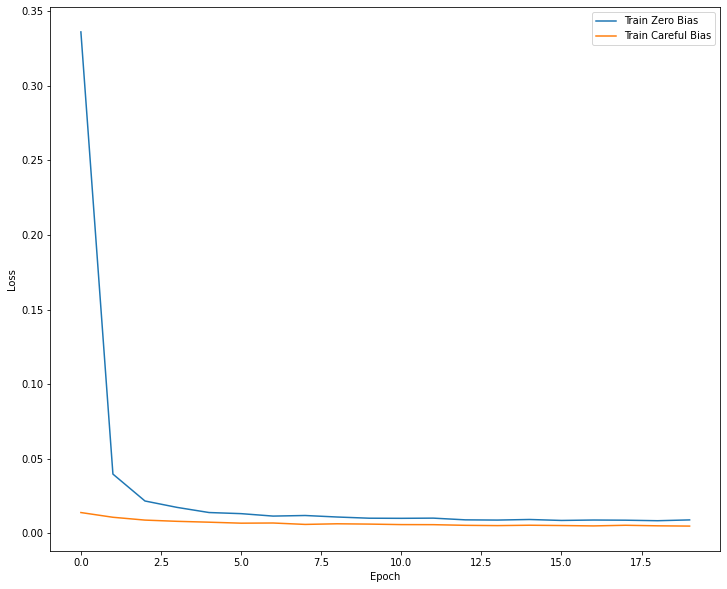

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

Clearly the model with a careful initialization converges faster. Therefore, we are going to use it.

### Training the model

Given that, let's train the model, using cross validation. First, we write a function to plot the metrics.

In [ ]:
def plot_metrics(history,color_num = 0, stack = 0, validation = 1):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    
    name = metric.replace("_"," ").capitalize()
    
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric],color = colors[color_num], 
             label='Train')
    
    if validation == 1:
      plt.plot(history.epoch, history.history['val_'+metric],
              colors[color_num], linestyle="--", label='Val')
    
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

    #show figures stacked or side-to-side
    if stack == 1:
      plt.show()
    

In [ ]:
pip install -q pyyaml h5py

We are going to use Stratified k-fold cross validation in order to preserve the imbalance of the data set in each fold.

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

Y = train_df[['Class']]
                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)

n_samples = len(Y)

Auxiliary function for getting model name in each of the k iterations:

In [ ]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

We are going to use two callbacks during each step of cross-validation: 

- ModelCheckpoint, to save the model that has the higher AUC during validation; 
- EarlyStopping, to stop training if the model does not improve the validation AUC after 10 epochs.  

After cross-validation, we calculate the mean and standard deviation of the metrics for all folds (accuracy, precision, recall and AUC). 

------------------------------------------------------------------------
Training for fold 1 ...


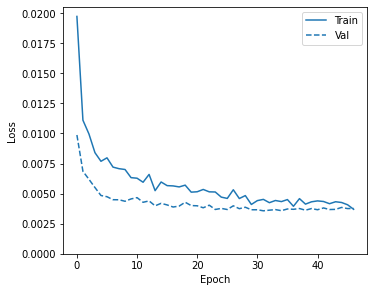

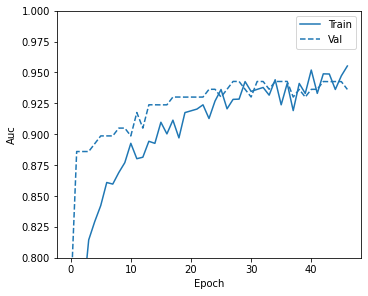

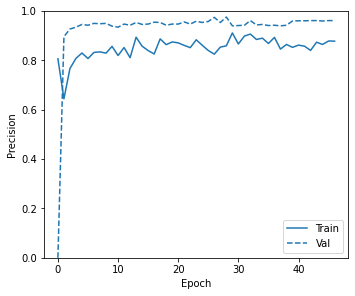

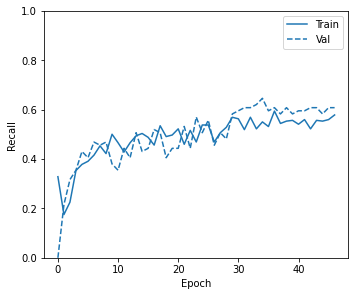

------------------------------------------------------------------------
Training for fold 2 ...


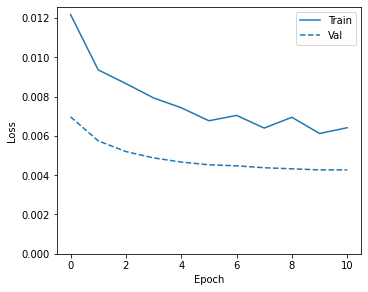

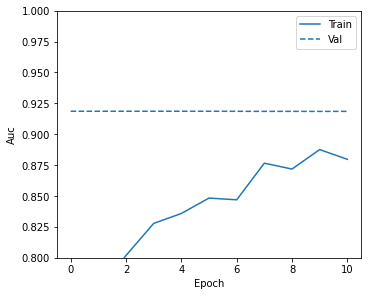

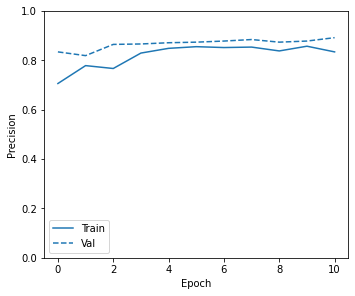

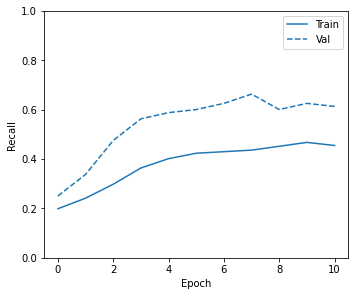

------------------------------------------------------------------------
Training for fold 3 ...


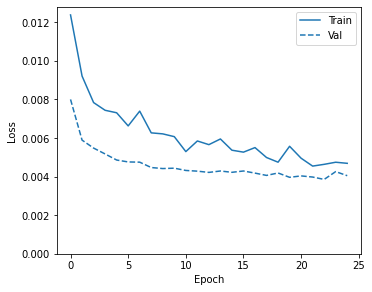

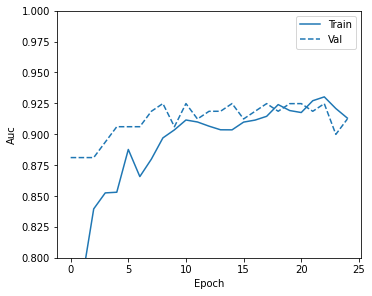

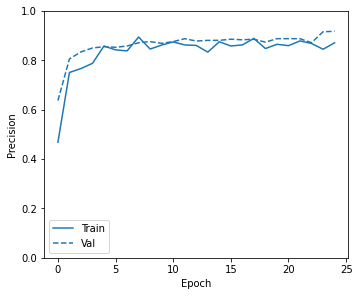

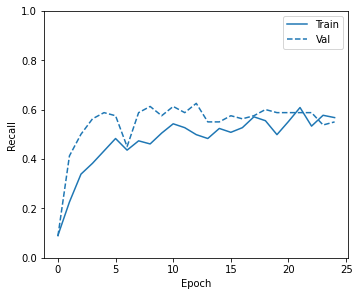

------------------------------------------------------------------------
Training for fold 4 ...


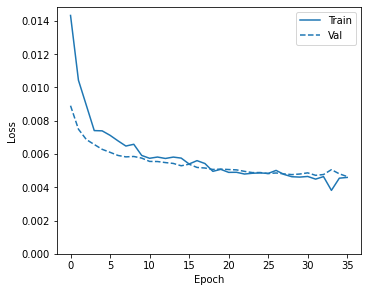

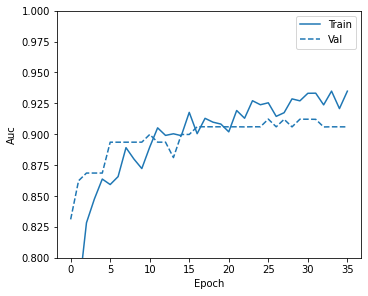

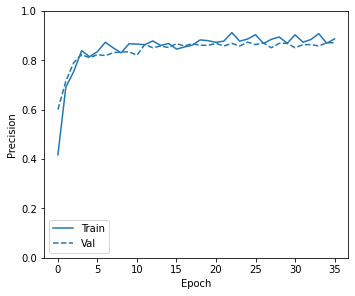

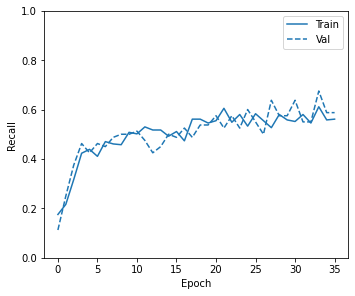

------------------------------------------------------------------------
Training for fold 5 ...


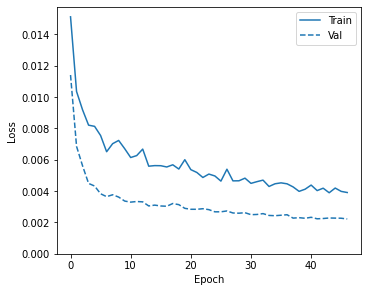

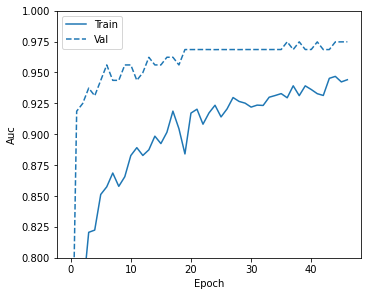

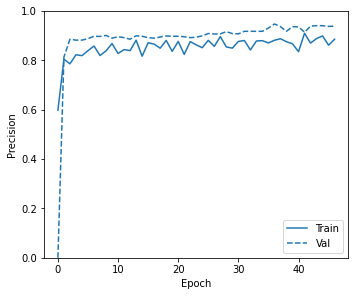

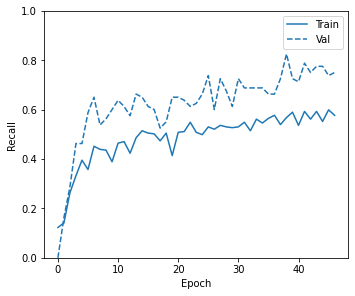

Accuracy:  0.9990651607513428 +/- 0.00025801716571616614
Precision:  0.8927366971969605 +/- 0.044316392435618836
Recall:  0.5240189909934998 +/- 0.14324689495026915
AUC:  0.9346696019172669 +/- 0.022508397369125386


In [ ]:
from keras import layers
from keras import models

VALIDATION_ACCURACY = []
VALIDATION_PRECISION = []
VALIDATION_RECALL = []
VALIDATION_AUC = []

save_dir = '/content/'
fold_var = 1

EPOCHS = 100
BATCH_SIZE = 2048

for train_index, val_index in skf.split(np.zeros(n_samples),Y):
  train_data_kfold = train_df_features.iloc[train_index]
  val_data_kfold = train_df_features.iloc[val_index]

  train_labels_kfold = train_df_labels.iloc[train_index]
  val_labels_kfold = train_df_labels.iloc[val_index]

  # Convert the DataFrame into np arrays of labels and features.
  train_features_kfold = np.array(train_data_kfold)
  val_features_kfold = np.array(val_data_kfold)
  
  train_labels_kfold = np.array(train_labels_kfold)
  val_labels_kfold = np.array(val_labels_kfold)

  # Build the model.
  model = make_model(output_bias = initial_bias)
  
  # Create Callbacks save the best model
  # This saves the best model
  checkpoint = tf.keras.callbacks.ModelCheckpoint(get_model_name(fold_var), 
              monitor='val_auc', verbose=0, 
              save_best_only=True, mode='max')

  # This is for early stopping
  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)
  
  #List of callbacks
  callbacks_list = [checkpoint, early_stopping]  

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_var} ...')

  # Fit the Model  
  baseline_history_kfold = model.fit(
    train_features_kfold,
    train_labels_kfold,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = callbacks_list,
    validation_data=(val_features_kfold, val_labels_kfold),
    verbose=0)

  #Plot history
  plot_metrics(baseline_history_kfold, color_num = 0, stack=1)

  # Load best model to evaluate the performance of the model
  model.load_weights(get_model_name(fold_var))

  baseline_results_kfold = model.evaluate(val_features_kfold, val_labels_kfold,
                                  batch_size=BATCH_SIZE, verbose=0)

  VALIDATION_ACCURACY.append(baseline_results_kfold[5])
  VALIDATION_PRECISION.append(baseline_results_kfold[6])
  VALIDATION_RECALL.append(baseline_results_kfold[7])
  VALIDATION_AUC.append(baseline_results_kfold[8])

  tf.keras.backend.clear_session()

  fold_var += 1

print("Accuracy: ", np.mean(VALIDATION_ACCURACY), "+/-", np.std(VALIDATION_ACCURACY))
print("Precision: ", np.mean(VALIDATION_PRECISION), "+/-", np.std(VALIDATION_PRECISION))
print("Recall: ", np.mean(VALIDATION_RECALL), "+/-", np.std(VALIDATION_RECALL))
print("AUC: ", np.mean(VALIDATION_AUC), "+/-", np.std(VALIDATION_AUC))

The model is not overfitting, and seems to be generalizing well.

Knowing that, we can train using the whole training dataset.

In [ ]:
model_baseline = make_model(output_bias = initial_bias)

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1984      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='auc', 
  verbose=0,
  patience=10,
  mode='max',
  restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model_baseline.h5", 
            monitor='auc', verbose=0, 
            save_best_only=True, mode='max')
  
#List of callbacks
callbacks_list = [checkpoint, early_stopping]  

baseline_history = model_baseline.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = callbacks_list,
    verbose=1)


Epoch 1/100
112/112 [==============================] - 2s 14ms/step - loss: 0.0120 - tp: 86.0000 - fp: 44.0000 - tn: 272891.0000 - fn: 393.0000 - accuracy: 0.9984 - precision: 0.6615 - recall: 0.1795 - auc: 0.7315
Epoch 2/100
112/112 [==============================] - 2s 14ms/step - loss: 0.0089 - tp: 105.0000 - fp: 37.0000 - tn: 227409.0000 - fn: 294.0000 - accuracy: 0.9985 - precision: 0.7394 - recall: 0.2632 - auc: 0.8248
Epoch 3/100
112/112 [==============================] - 1s 13ms/step - loss: 0.0071 - tp: 162.0000 - fp: 33.0000 - tn: 227413.0000 - fn: 237.0000 - accuracy: 0.9988 - precision: 0.8308 - recall: 0.4060 - auc: 0.8590
Epoch 4/100
112/112 [==============================] - 2s 14ms/step - loss: 0.0073 - tp: 168.0000 - fp: 38.0000 - tn: 227408.0000 - fn: 231.0000 - accuracy: 0.9988 - precision: 0.8155 - recall: 0.4211 - auc: 0.8733
Epoch 5/100
112/112 [==============================] - 2s 14ms/step - loss: 0.0067 - tp: 170.0000 - fp: 34.0000 - tn: 227412.0000 - fn: 229.0

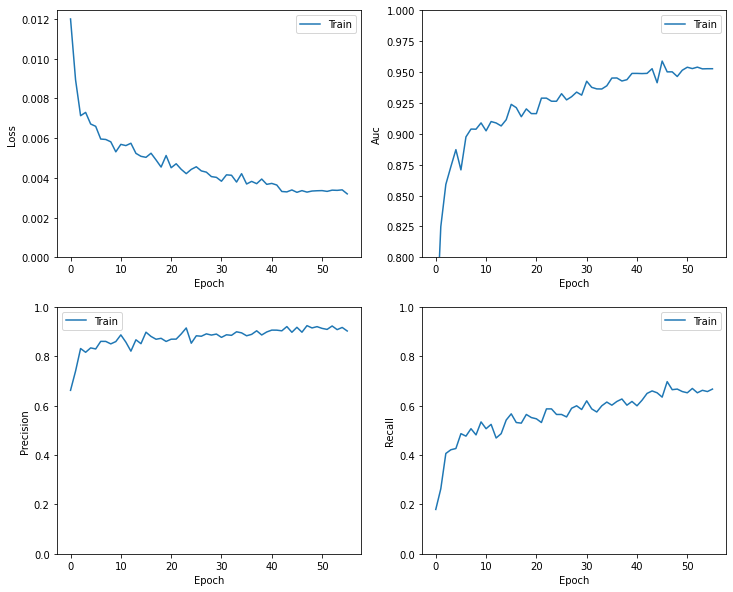

In [ ]:
plot_metrics(baseline_history, color_num = 0, stack=0, validation = 0)

### Metrics evaluation

For this kind of problem, it is good to use a confusion matrix to get an idea of how well the model is classifying the positive and negative samples.

We begin by writing a function to plot the confusion matrix, using sklearn.

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Let' evaluate how the model performs.

In [ ]:
# Load best model to evaluate performance
model_baseline.load_weights("best_model_baseline.h5")

test_predictions_baseline = model_baseline.predict(test_features, batch_size=BATCH_SIZE)
train_predictions_baseline = model_baseline.predict(train_features, batch_size=BATCH_SIZE)

loss :  0.0026508644223213196
tp :  74.0
fp :  12.0
tn :  56857.0
fn :  19.0
accuracy :  0.9994557499885559
precision :  0.8604651093482971
recall :  0.7956989407539368
auc :  0.9565940499305725

Legitimate Transactions Detected (True Negatives):  56857
Legitimate Transactions Incorrectly Detected (False Positives):  12
Fraudulent Transactions Missed (False Negatives):  19
Fraudulent Transactions Detected (True Positives):  74
Total Fraudulent Transactions:  93


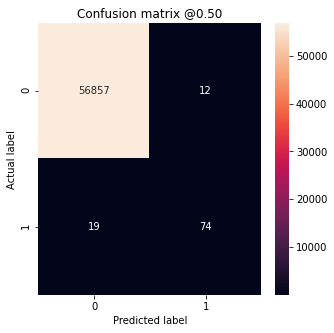

In [ ]:
test_baseline_results = model_baseline.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model_baseline.metrics_names, test_baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

The model has a very  high precision, which means that when it calls positive, it is right in most of the time. That is, few legitimate transactions were incorrectly classified as fraudulent. 

However, the not so high recall means that from all the positive samples, the model detected only a few of them, which means that many of the positive samples, or frauds, were incorrectly classified as legitimate.

These are not good results in the context of this problem. Although the number of legitimate transactions classified as frauds is low, the number of undetected frauds is too high. Both cases decrease the customer's happiness, but the second case is certainly much worse than the first, as it will also involve financial costs and decrease the customer's confidence in the bank's security system. Therefore, it would be better to increase the number of detected frauds (true positives), even if that results in more legitimate transactions being classified as frauds (false positives). 

###Plot the ROC curve

Plot the ROC curve and calculate the AUC.

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  #plt.xlim([-1,100.5]) #Total
  #plt.ylim([-1,100.5]) #Total
  plt.xlim([-0.5,20]) #Better visualization
  plt.ylim([80,100.5]) #Better visualization
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

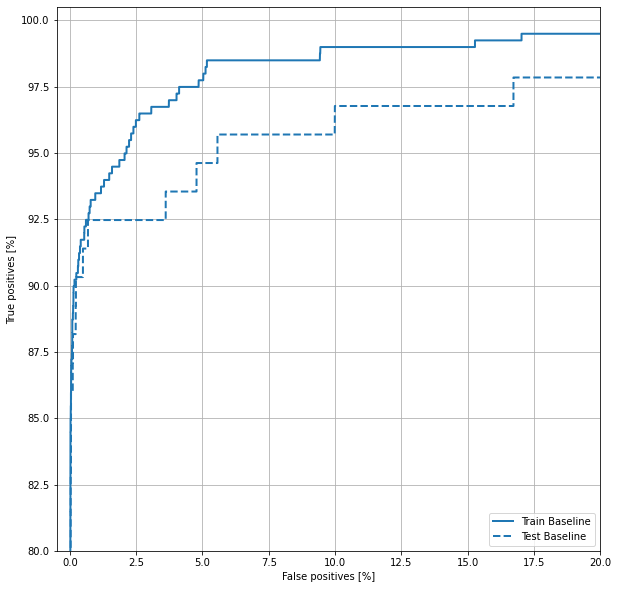

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

##Class weights

The fact that there are too few positive samples compared to the large amount of negative samples is a problem that cannot be neglected. A way to improve this model is to put weight on the positive samples, that is, forcing the model to "pay more attention" to the positive samples. This is done by passing Keras weights for each class through a parameter. 

Let's see how this improve our results. First, we need to define the weights:

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


The scaling by total/2 is needed to keep the loss to a similar magnitude. 

### Train a model with class weights



------------------------------------------------------------------------
Training for fold 1 ...


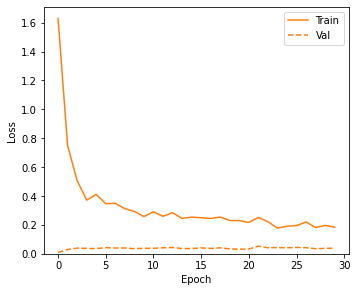

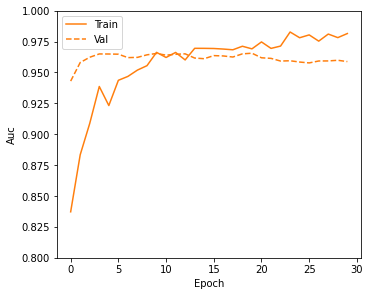

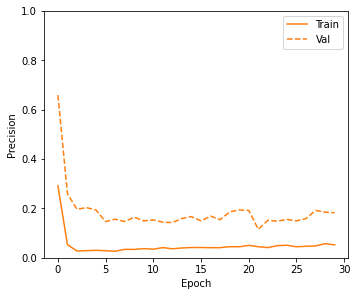

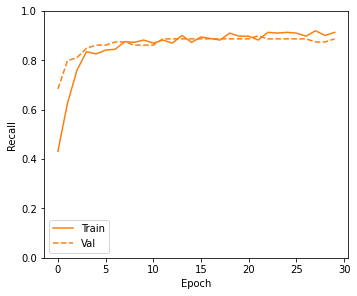

------------------------------------------------------------------------
Training for fold 2 ...


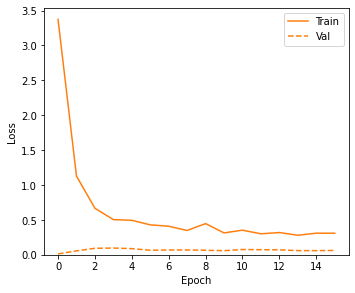

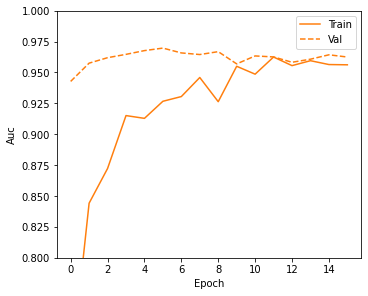

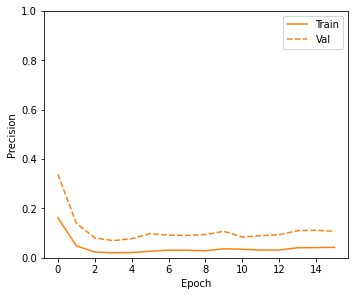

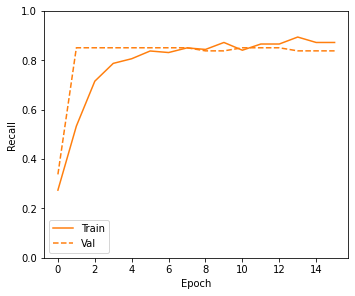

------------------------------------------------------------------------
Training for fold 3 ...


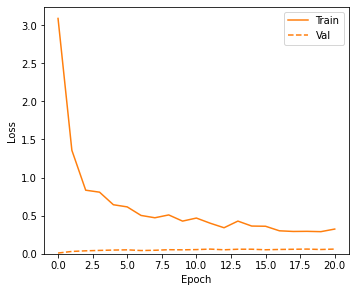

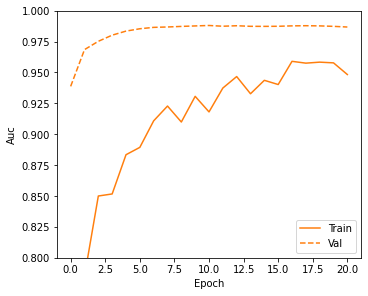

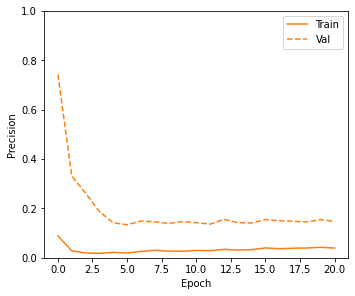

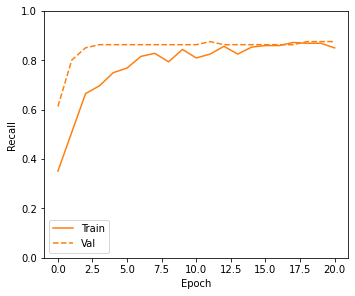

------------------------------------------------------------------------
Training for fold 4 ...


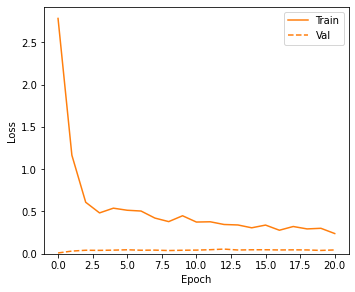

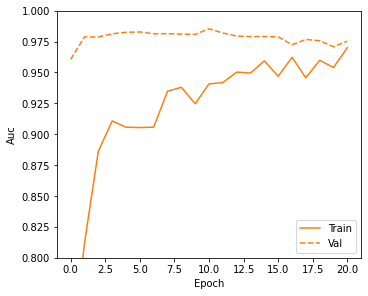

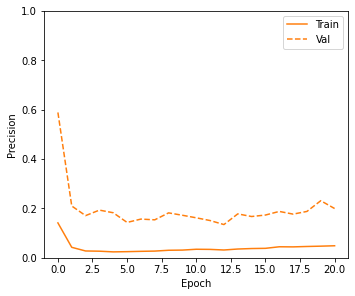

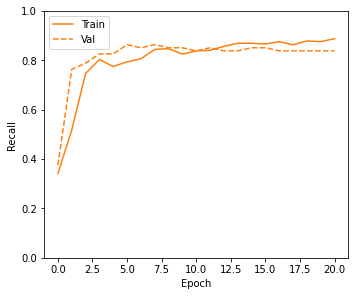

------------------------------------------------------------------------
Training for fold 5 ...


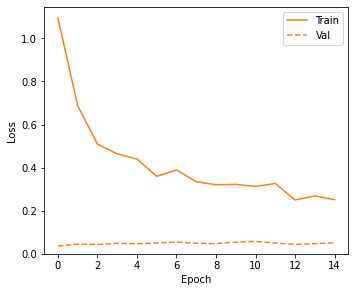

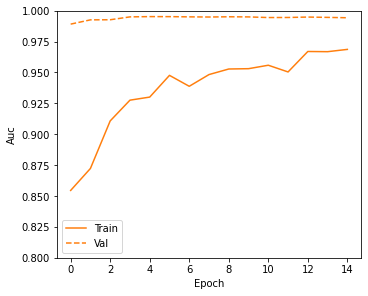

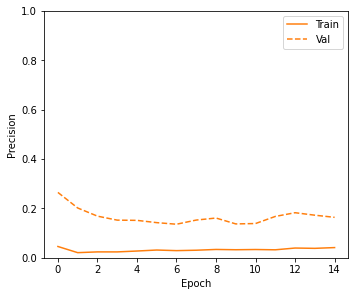

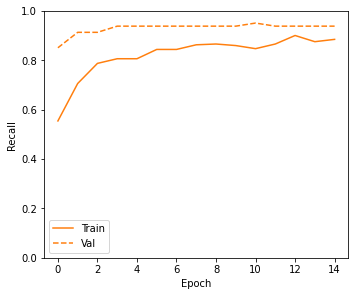

Accuracy:  0.9905637502670288 +/- 0.002503973141130951
Precision:  0.1495014950633049 +/- 0.031094822710624057
Recall:  0.8747151970863343 +/- 0.035259103572657664
AUC:  0.9807948708534241 +/- 0.011268787000315477


In [ ]:
VALIDATION_ACCURACY = []
VALIDATION_PRECISION = []
VALIDATION_RECALL = []
VALIDATION_AUC = []

save_dir = '/content/'
fold_var = 1

EPOCHS = 100
BATCH_SIZE = 2048

scaler = StandardScaler()

for train_index, val_index in skf.split(np.zeros(n_samples),Y):
  train_data_kfold = train_df_features.iloc[train_index]
  val_data_kfold = train_df_features.iloc[val_index]

  train_labels_kfold = train_df_labels.iloc[train_index]
  val_labels_kfold = train_df_labels.iloc[val_index]

  # Convert the DataFrame into np arrays of labels and features.
  train_features_kfold = np.array(train_data_kfold)
  val_features_kfold = np.array(val_data_kfold)
  
  train_labels_kfold = np.array(train_labels_kfold)
  val_labels_kfold = np.array(val_labels_kfold)

  # Build the model.
  model = make_model(output_bias = initial_bias)
  
  # Create Callbacks save the best model
  # This saves the best model
  checkpoint = tf.keras.callbacks.ModelCheckpoint(get_model_name(fold_var), 
              monitor='val_auc', verbose=0, 
              save_best_only=True, mode='max')

  # This is for early stopping
  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)
  
  #List of callbacks
  callbacks_list = [checkpoint, early_stopping]  

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_var} ...')

  # Fit the Model  
  weighted_history_kfold = model.fit(
    train_features_kfold,
    train_labels_kfold,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = callbacks_list,
    validation_data=(val_features_kfold, val_labels_kfold),
    class_weight=class_weight, # Here we define the class weights
    verbose=0)

  #PLOT HISTORY
  plot_metrics(weighted_history_kfold, color_num = 1, stack=1)

  # LOAD BEST MODEL to evaluate the performance of the model
  model.load_weights(get_model_name(fold_var))

  weighted_results_kfold = model.evaluate(val_features_kfold, val_labels_kfold,
                                  batch_size=BATCH_SIZE, verbose=0)

  VALIDATION_ACCURACY.append(weighted_results_kfold[5])
  VALIDATION_PRECISION.append(weighted_results_kfold[6])
  VALIDATION_RECALL.append(weighted_results_kfold[7])
  VALIDATION_AUC.append(weighted_results_kfold[8])

  tf.keras.backend.clear_session()

  fold_var += 1

print("Accuracy: ", np.mean(VALIDATION_ACCURACY), "+/-", np.std(VALIDATION_ACCURACY))
print("Precision: ", np.mean(VALIDATION_PRECISION), "+/-", np.std(VALIDATION_PRECISION))
print("Recall: ", np.mean(VALIDATION_RECALL), "+/-", np.std(VALIDATION_RECALL))
print("AUC: ", np.mean(VALIDATION_AUC), "+/-", np.std(VALIDATION_AUC))

As the model is not overfitting and generalizes well for all data, we can train on the whole training dataset.

In [ ]:
model_weighted = make_model(output_bias = initial_bias)

model_weighted.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1984      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='auc', 
  verbose=0,
  patience=10,
  mode='max',
  restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model_weighted.h5", 
            monitor='auc', verbose=0, 
            save_best_only=True, mode='max')
  
#List of callbacks
callbacks_list = [checkpoint, early_stopping]  

weighted_history = model_weighted.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = callbacks_list,
    class_weight = class_weight, # Here we define the class weights
    verbose=1)

Epoch 1/100
112/112 [==============================] - 2s 14ms/step - loss: 2.4179 - tp: 185.0000 - fp: 1104.0000 - tn: 271831.0000 - fn: 294.0000 - accuracy: 0.9949 - precision: 0.1435 - recall: 0.3862 - auc: 0.7459
Epoch 2/100
112/112 [==============================] - 2s 14ms/step - loss: 1.0023 - tp: 239.0000 - fp: 5732.0000 - tn: 221714.0000 - fn: 160.0000 - accuracy: 0.9741 - precision: 0.0400 - recall: 0.5990 - auc: 0.8187
Epoch 3/100
112/112 [==============================] - 2s 14ms/step - loss: 0.6174 - tp: 296.0000 - fp: 11809.0000 - tn: 215637.0000 - fn: 103.0000 - accuracy: 0.9477 - precision: 0.0245 - recall: 0.7419 - auc: 0.8833
Epoch 4/100
112/112 [==============================] - 2s 14ms/step - loss: 0.5378 - tp: 308.0000 - fp: 14152.0000 - tn: 213294.0000 - fn: 91.0000 - accuracy: 0.9375 - precision: 0.0213 - recall: 0.7719 - auc: 0.9059
Epoch 5/100
112/112 [==============================] - 2s 14ms/step - loss: 0.4733 - tp: 322.0000 - fp: 13666.0000 - tn: 213780.000

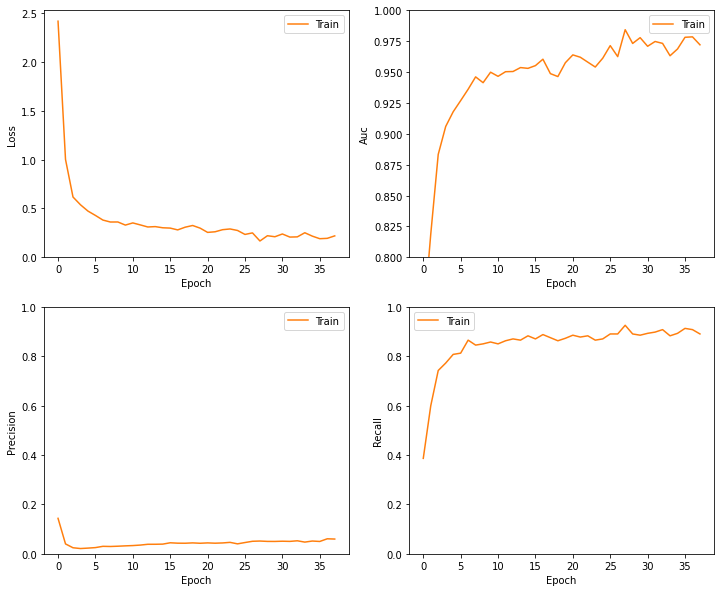

In [ ]:
plot_metrics(weighted_history, color_num = 1, stack=0, validation = 0)

### Evaluate metrics and confusion matrix:

loss :  0.0627945065498352
tp :  84.0
fp :  433.0
tn :  56436.0
fn :  9.0
accuracy :  0.9922404289245605
precision :  0.1624758243560791
recall :  0.9032257795333862
auc :  0.9868484735488892

Legitimate Transactions Detected (True Negatives):  56436
Legitimate Transactions Incorrectly Detected (False Positives):  433
Fraudulent Transactions Missed (False Negatives):  9
Fraudulent Transactions Detected (True Positives):  84
Total Fraudulent Transactions:  93


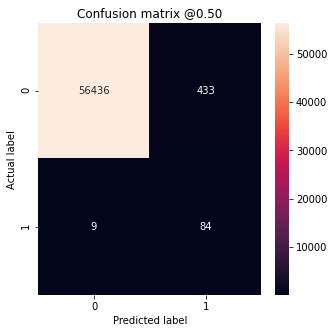

In [ ]:
#Load best model to evaluate performance
model_weighted.load_weights("best_model_weighted.h5")

train_predictions_weighted = model_weighted.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = model_weighted.predict(test_features, batch_size=BATCH_SIZE)

weighted_results = model_weighted.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model_weighted.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

With the class weights, the model could detect more fradulent transactions, with a high AUC. This is a nice result, but comes with the downside of classifying 996 legitimate transactions as fraudulent. But, as discussed before, this is better than missing positive samples. This is all reflected by the high recall the high recall and low precision.


###Plot the ROC curve

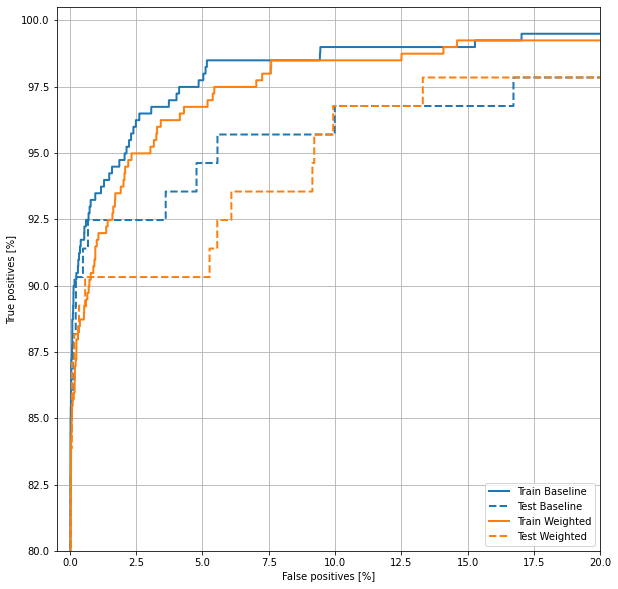

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')

## Random undersampling 

A third alternative to solve the imbalance problem is to implement "Random Under Sampling", which consists of removing data from the majority class (non-fraud) in order to have a balanced dataset:

1. First, we determine how many fraud samples there are (we already did this, there are 492 fraud samples).
2. Then, we bring that same amount of non-fraud transactions (chosen randomly) and put them together into a new dataframe, which will have a 50/50 ratio of fraud and non-fraud transactions. 

The problem with doing the Random under-sampling is the risk to lose information, as we are taking only 492 non-fraud samples from a set of 284,314. 

In [ ]:
# amount of fraud classes 492 rows.
fraud_df = raw_df.loc[raw_df['Class'] == 1]
non_fraud_df = raw_df.loc[raw_df['Class'] == 0]
non_fraud_df = non_fraud_df.sample(n=492, random_state=42)

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
under_df = normal_distributed_df.sample(frac=1, random_state=42)

under_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000
mean,87899.782520,-2.309318,1.816713,-3.535655,2.257353,-1.544629,-0.725850,-2.777468,0.292773,-1.271887,-2.820320,1.905015,-3.131755,-0.026672,-3.477570,-0.037294,-2.064206,-3.328861,-1.129523,0.344327,0.193675,0.363824,-0.003366,-0.013543,-0.056194,0.033048,0.011976,0.090822,0.036681,101.279837,0.500000
std,47991.767211,5.523248,3.675483,6.200540,3.207699,4.205316,1.726953,5.845730,4.859601,2.340829,4.548610,2.767834,4.588050,1.058070,4.666041,0.965780,3.474123,5.970771,2.403651,1.256505,1.057446,2.806097,1.170228,1.164365,0.578977,0.677074,0.469889,0.999413,0.415091,221.764524,0.500254
min,406.000000,-30.552380,-8.402154,-31.103685,-4.519509,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,-24.588262,-2.382493,-18.683715,-3.303923,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-3.681904,-5.680478,-22.797604,-8.887017,-19.254328,-2.836627,-4.781606,-1.178778,-7.263482,-1.869290,0.000000,0.000000
25%,45928.000000,-2.784711,-0.150957,-5.084967,-0.140560,-1.775001,-1.599839,-3.066415,-0.228822,-2.353917,-4.572043,-0.182444,-5.495221,-0.781885,-6.721799,-0.605126,-3.543426,-5.302111,-1.772498,-0.413258,-0.189955,-0.164947,-0.541855,-0.245208,-0.399495,-0.309954,-0.297013,-0.062727,-0.056989,1.180000,0.000000
50%,80853.000000,-0.784459,0.940617,-1.369045,1.302623,-0.340291,-0.671683,-0.635248,0.146863,-0.702318,-0.865787,1.089117,-0.816557,0.030282,-1.009716,0.000831,-0.597642,-0.515190,-0.345936,0.220248,0.026555,0.136882,0.035879,-0.035509,0.009479,0.058178,-0.014392,0.042484,0.031986,16.880000,0.500000
75%,134528.250000,1.125429,2.798885,0.225959,4.202830,0.492184,0.073437,0.286374,0.867939,0.192528,0.025215,3.586502,0.238259,0.677682,0.144960,0.644701,0.290075,0.227409,0.349343,0.936946,0.464790,0.655130,0.553477,0.192580,0.381696,0.401022,0.289880,0.455390,0.211934,99.990000,1.000000
max,171917.000000,2.351891,22.057729,3.143387,12.114672,11.095089,6.474115,5.802537,20.007208,5.232322,9.386945,12.018913,1.928119,3.093988,3.442422,2.471358,3.139656,6.739384,3.790316,5.228342,11.059004,27.202839,8.361985,6.008724,1.205581,2.208209,2.745261,3.052358,1.779364,2125.870000,1.000000


In [ ]:
neg_under, pos_under = np.bincount(under_df['Class'])
total_under = neg_under + pos_under
print('Examples:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_under, neg_under, 100 * neg_under / total_under, pos_under, 100 * pos_under / total_under))

Examples:
  Total: 984
  Negative: 492 (50.00% of total)
  Positive: 492 (50.00% of total)



In [ ]:
train_under_df, test_under_df = train_test_split(under_df, test_size=0.2)

train_under_df_features = train_under_df.copy()
test_under_df_features = test_under_df.copy()

train_under_df_labels = train_under_df_features.pop('Class')
test_under_df_labels = test_under_df_features.pop('Class')

# Count the negatives and positives
neg_under_train, pos_under_train = np.bincount(train_under_df_labels)
total_under_train = neg_under_train + pos_under_train

neg_under_test, pos_under_test = np.bincount(test_under_df_labels)
total_under_test = neg_under_test + pos_under_test

print('Train:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_under_train, neg_under_train, 100 * neg_under_train / total_under_train,
    pos_under_train, 100 * pos_under_train / total_under_train))


print('Test:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_under_test, neg_under_test, 100 * neg_under_test / total_under_test, 
    pos_under_test, 100 * pos_under_test / total_under_test))

Train:
  Total: 787
  Negative: 401 (50.95% of total)
  Positive: 386 (49.05% of total)

Test:
  Total: 197
  Negative: 91 (46.19% of total)
  Positive: 106 (53.81% of total)



In [ ]:
scaler = StandardScaler()

train_under_scaled = StandardScaler().fit_transform(train_under_df_features.values)

train_under_df_features = pd.DataFrame(train_under_scaled, index=train_under_df_features.index, 
                                 columns=train_under_df_features.columns)                                        

test_under_scaled = StandardScaler().fit_transform(test_under_df_features.values)

test_under_df_features = pd.DataFrame(test_under_scaled, index=test_under_df_features.index, 
                                columns=test_under_df_features.columns)                       
                                              

print('Training features shape:', train_under_df_features.shape)
print('Training labels shape:', train_under_df_labels.shape, "\n")

print('Test features shape:', test_under_df_features.shape)
print('Test labels shape:', test_under_df_labels.shape)

Training features shape: (787, 30)
Training labels shape: (787,) 

Test features shape: (197, 30)
Test labels shape: (197,)


In [ ]:
train_under_df_features.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02
mean,-8.647608e-17,5.861470e-17,2.821405e-17,-6.841908e-18,-2.038465e-17,8.499484e-18,1.848021e-17,-9.592778e-18,5.872050e-17,8.097433e-17,3.805371e-17,-2.953659e-18,-8.892717e-17,-9.169568e-18,-3.230509e-17,-5.918118e-17,1.438917e-17,-1.219420e-16,2.795836e-17,8.182076e-18,-5.586383e-17,3.491489e-17,5.748614e-18,-1.410703e-18,5.713346e-18,5.120851e-17,1.622308e-17,-1.906212e-17,1.664629e-17,-2.595693e-17
std,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00
min,-1.838302e+00,-5.164391e+00,-2.795929e+00,-4.455439e+00,-2.109674e+00,-4.962990e+00,-3.338338e+00,-7.354126e+00,-9.600071e+00,-5.331151e+00,-4.951685e+00,-1.543841e+00,-3.431739e+00,-3.049126e+00,-3.273111e+00,-3.778977e+00,-3.547664e+00,-3.562948e+00,-3.588207e+00,-3.278946e+00,-5.907218e+00,-9.796643e+00,-8.459308e+00,-1.801551e+01,-4.754970e+00,-7.242426e+00,-2.506373e+00,-7.553551e+00,-4.515381e+00,-4.673302e-01
25%,-8.996833e-01,-8.715974e-02,-5.280696e-01,-2.491453e-01,-7.374192e-01,-4.165777e-02,-4.862598e-01,-7.419834e-02,-1.541192e-01,-4.985243e-01,-3.968692e-01,-7.487638e-01,-5.367553e-01,-7.142745e-01,-6.965097e-01,-6.034367e-01,-4.165646e-01,-3.296337e-01,-2.752235e-01,-6.198022e-01,-3.862892e-01,-2.142166e-01,-5.122050e-01,-2.109935e-01,-5.992142e-01,-5.278321e-01,-6.497895e-01,-1.648204e-01,-1.959744e-01,-4.617188e-01
50%,-1.332500e-01,2.747168e-01,-2.316038e-01,3.481614e-01,-3.077380e-01,2.821507e-01,4.954790e-02,3.640160e-01,-7.127716e-02,2.414915e-01,4.372012e-01,-3.064757e-01,5.034255e-01,3.864140e-02,5.422508e-01,4.216164e-02,4.244482e-01,4.683164e-01,3.199279e-01,-9.433192e-02,-1.709101e-01,-8.965139e-02,1.857526e-02,-9.474479e-03,1.159597e-01,2.927461e-02,-4.941964e-02,-6.763026e-02,1.115158e-02,-3.890317e-01
75%,9.664039e-01,6.151262e-01,2.809249e-01,5.995830e-01,5.984878e-01,4.726316e-01,4.805206e-01,5.294904e-01,1.076044e-01,6.262383e-01,6.237227e-01,6.197587e-01,7.266813e-01,6.445303e-01,7.745246e-01,7.343704e-01,6.717489e-01,5.927947e-01,6.098058e-01,4.803454e-01,2.905470e-01,1.341291e-01,5.212671e-01,1.955379e-01,7.430863e-01,5.511938e-01,5.921591e-01,3.318504e-01,4.180551e-01,-3.238211e-02
max,1.733077e+00,8.347752e-01,5.625402e+00,1.073723e+00,3.088792e+00,2.747373e+00,4.239411e+00,1.515516e+00,4.529207e+00,2.834981e+00,2.742622e+00,3.535718e+00,1.088834e+00,2.987413e+00,1.357638e+00,2.598175e+00,1.508846e+00,1.710160e+00,2.087159e+00,3.985241e+00,1.094487e+01,1.137357e+01,7.941510e+00,5.634386e+00,2.182049e+00,3.275965e+00,5.875568e+00,3.019767e+00,4.158201e+00,8.780026e+00


In [ ]:
test_under_df_features.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02,1.970000e+02
mean,-1.087680e-16,-9.242466e-17,-8.566188e-17,-4.508520e-17,7.889910e-17,4.057668e-17,3.944955e-17,-7.326345e-17,4.508520e-18,2.479686e-17,2.930538e-17,-1.318742e-16,4.057668e-17,-1.690695e-17,7.889910e-17,9.298822e-18,-2.028834e-17,2.028834e-17,-6.086502e-17,-4.057668e-17,-3.494103e-17,2.423329e-17,5.072085e-17,-1.127130e-18,1.465269e-17,2.254260e-17,-6.199215e-18,2.028834e-17,-4.283094e-17,3.268677e-17
std,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00,1.002548e+00
min,-1.752567e+00,-4.534939e+00,-2.088479e+00,-4.271781e+00,-1.925193e+00,-4.176495e+00,-2.588216e+00,-5.601835e+00,-5.913518e+00,-4.620803e+00,-4.225693e+00,-1.471861e+00,-3.195011e+00,-2.788103e+00,-3.448994e+00,-4.443909e+00,-2.758968e+00,-3.320186e+00,-2.980178e+00,-2.901084e+00,-2.901420e+00,-5.314954e+00,-5.718945e+00,-1.074096e+01,-3.292137e+00,-4.945028e+00,-2.434491e+00,-6.723610e+00,-3.833072e+00,-4.189323e-01
25%,-7.613561e-01,-4.260107e-02,-5.762936e-01,-2.705982e-01,-7.778684e-01,-8.154609e-02,-5.639421e-01,-1.450568e-02,1.038280e-02,-3.588224e-01,-3.413238e-01,-7.737066e-01,-4.874661e-01,-7.569898e-01,-6.723941e-01,-5.115735e-01,-3.963717e-01,-3.942751e-01,-2.824815e-01,-5.584237e-01,-3.054959e-01,-1.461693e-01,-3.323081e-01,-1.607136e-01,-6.194145e-01,-3.964817e-01,-7.151099e-01,-1.301773e-01,-3.541509e-01,-4.134699e-01
50%,-1.717080e-01,2.979582e-01,-2.731642e-01,3.651093e-01,-2.955344e-01,3.000419e-01,-3.637758e-02,3.839680e-01,7.403146e-02,2.446558e-01,4.204749e-01,-2.263651e-01,4.033319e-01,6.779783e-02,3.662229e-01,-4.727530e-04,4.049864e-01,4.821449e-01,3.501163e-01,-1.499875e-01,-1.349761e-01,-6.955539e-02,5.655269e-02,-3.785811e-02,7.169760e-02,6.399023e-02,-7.827248e-02,2.844789e-02,-8.248380e-02,-3.561142e-01
75%,9.500392e-01,5.342444e-01,2.115135e-01,6.267063e-01,6.210775e-01,5.148495e-01,3.710809e-01,5.243984e-01,1.644318e-01,5.957384e-01,6.327913e-01,5.454723e-01,7.474259e-01,7.350586e-01,7.946982e-01,6.649203e-01,7.096604e-01,6.180272e-01,6.330526e-01,4.611118e-01,1.728590e-01,4.743175e-02,3.739717e-01,1.170664e-01,7.775791e-01,4.990328e-01,6.081811e-01,4.367405e-01,4.467352e-01,1.348142e-03
max,1.776815e+00,8.565679e-01,4.977616e+00,1.081646e+00,2.924700e+00,2.889220e+00,3.703812e+00,8.339035e-01,2.778652e+00,1.663137e+00,1.556851e+00,3.632540e+00,1.128927e+00,2.381696e+00,1.537746e+00,2.131078e+00,1.313353e+00,1.594655e+00,1.541022e+00,2.758037e+00,7.988730e+00,6.487603e+00,5.333403e+00,3.589346e+00,1.846953e+00,2.742819e+00,5.046224e+00,1.926845e+00,4.352366e+00,7.801664e+00


Now all the features are scaled. Let's transform the dataframes into NumPy arrays:

In [ ]:
train_under_features = np.array(train_under_df_features)
test_under_features = np.array(test_under_df_features)

train_under_labels = np.array(train_under_df_labels)
test_under_labels = np.array(test_under_df_labels)

### Train a model with random under-sampling

As now the two classes are balanced, we can initialize the model with the default bias. Let's test run it:

In [ ]:
model_under = make_model()
model_under.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1984      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [ ]:
train_under_labels[:10]

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
model_under.predict(train_under_features[:10])

array([[0.7490651 ],
       [0.75280666],
       [0.77039826],
       [0.7487165 ],
       [0.74785334],
       [0.7605641 ],
       [0.7544502 ],
       [0.84222937],
       [0.72695744],
       [0.7408805 ]], dtype=float32)

In [ ]:
(model_under.predict(train_under_features[:10]) > 0.5).astype("int32")

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int32)

This is what is expected for the initial guesses, as now the dataset is balanced.

In [ ]:
#Now we don't need to use a huge batch size as the classes are balanced
BATCH_SIZE = 32

results = model_under.evaluate(train_under_features, train_under_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.8433


The initial loss is around the expected value of $ln(2) = 0.7282$.

Now let's perform cross-validation to see how the model generalizes in the training data:

In [ ]:
Y = train_under_df[['Class']]
                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)

n_samples = len(Y)

------------------------------------------------------------------------
Training for fold 1 ...


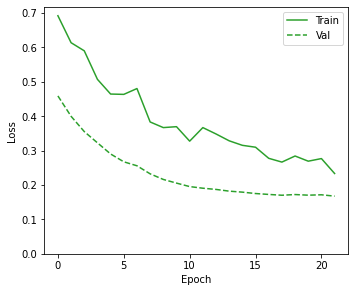

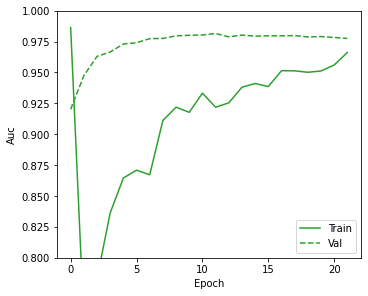

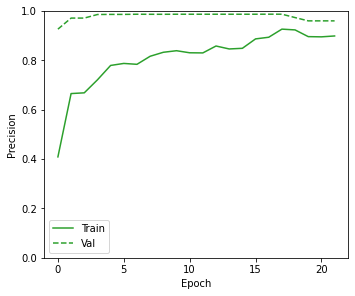

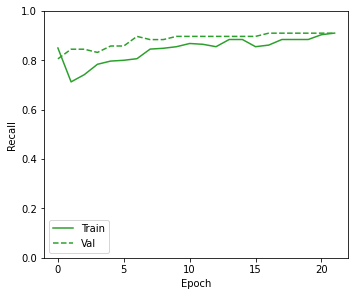

------------------------------------------------------------------------
Training for fold 2 ...


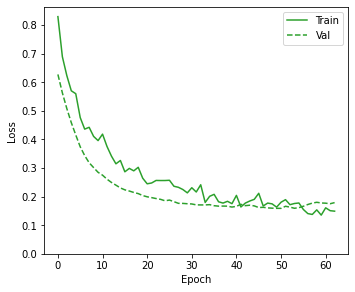

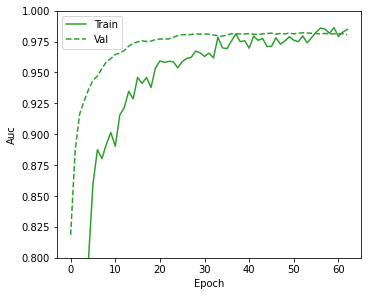

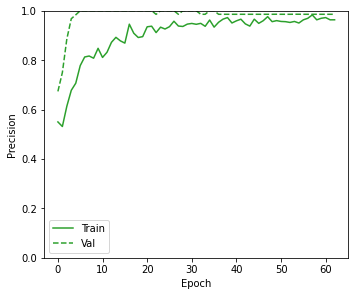

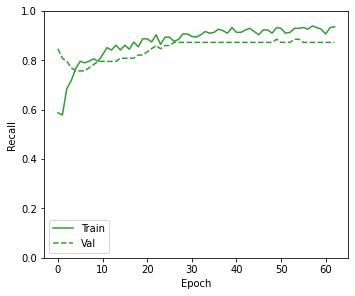

------------------------------------------------------------------------
Training for fold 3 ...


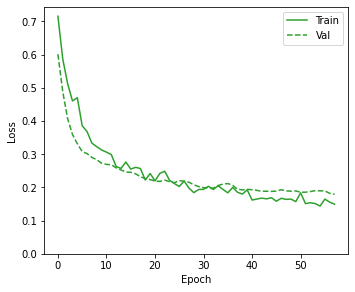

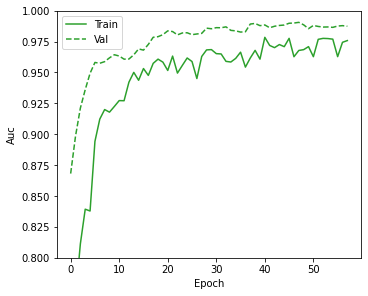

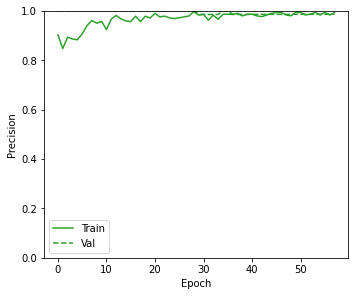

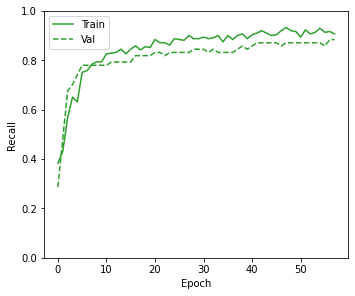

------------------------------------------------------------------------
Training for fold 4 ...


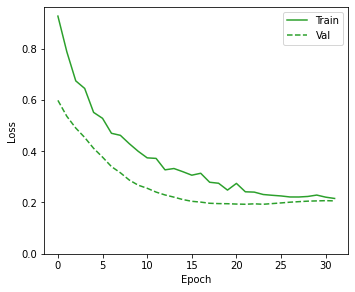

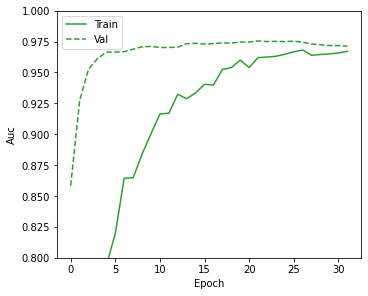

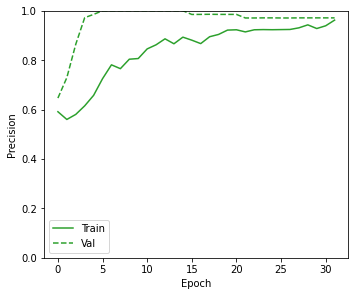

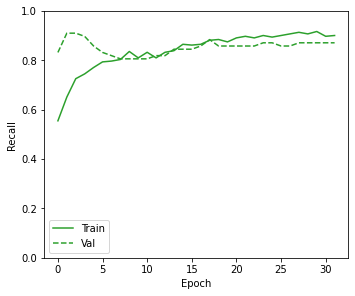

------------------------------------------------------------------------
Training for fold 5 ...


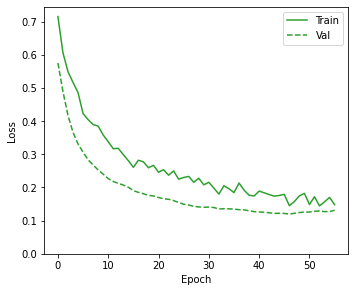

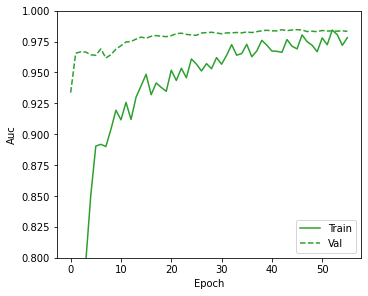

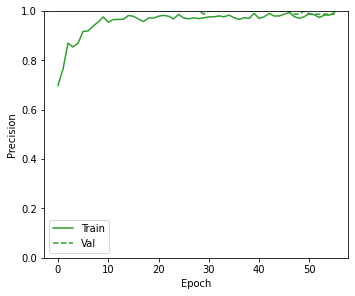

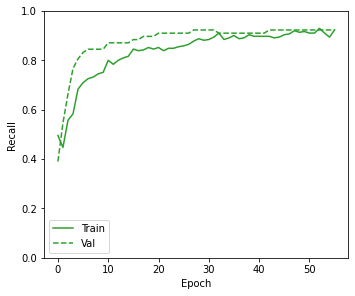

Accuracy:  0.9364669919013977 +/- 0.015067323642367078
Precision:  0.9854207634925842 +/- 0.009302349411738596
Recall:  0.8834498882293701 +/- 0.023054581009699617
AUC:  0.9829009532928467 +/- 0.004863777671892907


In [ ]:
VALIDATION_ACCURACY = []
VALIDATION_PRECISION = []
VALIDATION_RECALL = []
VALIDATION_AUC = []

save_dir = '/content/'
fold_var = 1

EPOCHS = 100
BATCH_SIZE = 32

for train_index, val_index in skf.split(np.zeros(n_samples),Y):
  train_data_kfold = train_under_df_features.iloc[train_index]
  val_data_kfold = train_under_df_features.iloc[val_index]

  train_labels_kfold = train_under_df_labels.iloc[train_index]
  val_labels_kfold = train_under_df_labels.iloc[val_index]

  # Convert the DataFrame into np arrays of labels and features.
  train_features_kfold = np.array(train_data_kfold)
  val_features_kfold = np.array(val_data_kfold)
  
  train_labels_kfold = np.array(train_labels_kfold)
  val_labels_kfold = np.array(val_labels_kfold)

  # Build the model.
  model = make_model()

  # Create Callbacks
  # This saves the best model
  checkpoint = tf.keras.callbacks.ModelCheckpoint(get_model_name(fold_var), 
              monitor='val_auc', verbose=0, 
              save_best_only=True, mode='max')

  # This is for early stopping
  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)
  
  #List of callbacks
  callbacks_list = [checkpoint, early_stopping]  

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_var} ...')

  # Fit the Model  
  under_history_kfold = model.fit(
    train_features_kfold,
    train_labels_kfold,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = callbacks_list,
    validation_data=(val_features_kfold, val_labels_kfold),
    verbose=0)

  #PLOT HISTORY
  plot_metrics(under_history_kfold, color_num = 2, stack=1)

  # LOAD BEST MODEL to evaluate the performance of the model
  model.load_weights(get_model_name(fold_var))

  under_results_kfold = model.evaluate(val_features_kfold, val_labels_kfold,
                                  batch_size=BATCH_SIZE, verbose=0)

  VALIDATION_ACCURACY.append(under_results_kfold[5])
  VALIDATION_PRECISION.append(under_results_kfold[6])
  VALIDATION_RECALL.append(under_results_kfold[7])
  VALIDATION_AUC.append(under_results_kfold[8])

  tf.keras.backend.clear_session()

  fold_var += 1

print("Accuracy: ", np.mean(VALIDATION_ACCURACY), "+/-", np.std(VALIDATION_ACCURACY))
print("Precision: ", np.mean(VALIDATION_PRECISION), "+/-", np.std(VALIDATION_PRECISION))
print("Recall: ", np.mean(VALIDATION_RECALL), "+/-", np.std(VALIDATION_RECALL))
print("AUC: ", np.mean(VALIDATION_AUC), "+/-", np.std(VALIDATION_AUC))


### Check training history

In [ ]:
model_under = make_model()

# This saves the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model_under.h5", 
            monitor='auc', verbose=0, 
            save_best_only=True, mode='max')

# This is for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='auc', 
  verbose=0,
  patience=10,
  mode='max',
  restore_best_weights=True)
  
#List of callbacks
callbacks_list = [checkpoint, early_stopping] 

under_history = model_under.fit(
    train_under_features,
    train_under_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = callbacks_list,
    verbose=1)

Epoch 1/100
25/25 [==============================] - 0s 3ms/step - loss: 0.8686 - tp: 339.0000 - fp: 299.0000 - tn: 182.0000 - fn: 124.0000 - accuracy: 0.5519 - precision: 0.5313 - recall: 0.7322 - auc: 0.6464
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7572 - tp: 275.0000 - fp: 265.0000 - tn: 136.0000 - fn: 111.0000 - accuracy: 0.5222 - precision: 0.5093 - recall: 0.7124 - auc: 0.6058
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6599 - tp: 294.0000 - fp: 219.0000 - tn: 182.0000 - fn: 92.0000 - accuracy: 0.6048 - precision: 0.5731 - recall: 0.7617 - auc: 0.7026
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6237 - tp: 291.0000 - fp: 200.0000 - tn: 201.0000 - fn: 95.0000 - accuracy: 0.6252 - precision: 0.5927 - recall: 0.7539 - auc: 0.7170
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5208 - tp: 314.0000 - fp: 158.0000 - tn: 243.0000 - fn: 72.0000 - accuracy: 0.7078 - pr

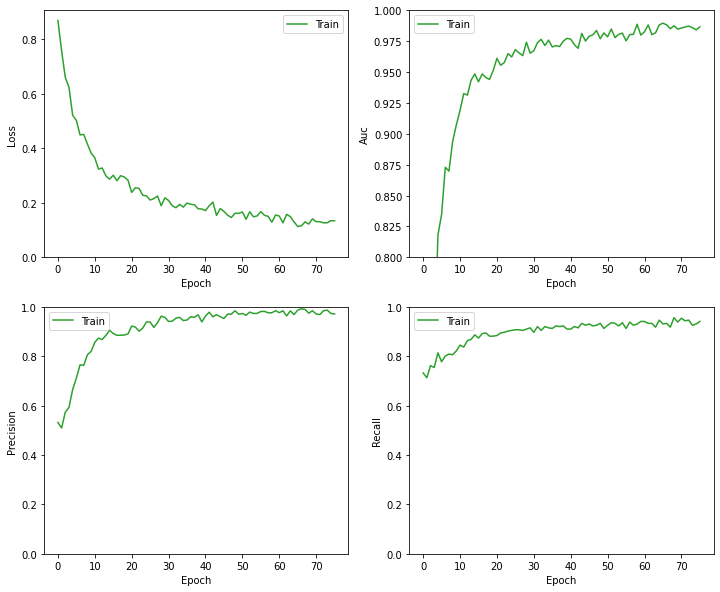

In [ ]:
plot_metrics(under_history, color_num = 2, stack=0, validation = 0)

### Evaluate metrics and confusion matrix:

In [ ]:
# Load best model to evaluate performance
model_under.load_weights("best_model_under.h5")

train_predictions_under = model_under.predict(train_under_features, batch_size=BATCH_SIZE)
test_predictions_under = model_under.predict(test_under_features, batch_size=BATCH_SIZE)

loss :  0.17862947285175323
tp :  96.0
fp :  2.0
tn :  89.0
fn :  10.0
accuracy :  0.9390863180160522
precision :  0.9795918464660645
recall :  0.9056603908538818
auc :  0.9779183268547058

Legitimate Transactions Detected (True Negatives):  89
Legitimate Transactions Incorrectly Detected (False Positives):  2
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  96
Total Fraudulent Transactions:  106


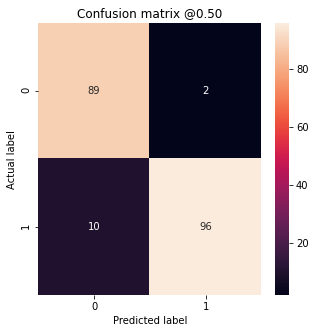

In [ ]:
under_results = model_under.evaluate(test_under_features, test_under_labels,
                                           batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model_under.metrics_names, under_results):
  print(name, ': ', value)
print()

plot_cm(test_under_labels, test_predictions_under)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  #plt.xlim([-1,100.5]) #Total
  #plt.ylim([-1,100.5]) #Total
  plt.xlim([-0.5,20]) #Better visualization
  plt.ylim([80,100.5]) #Better visualization
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

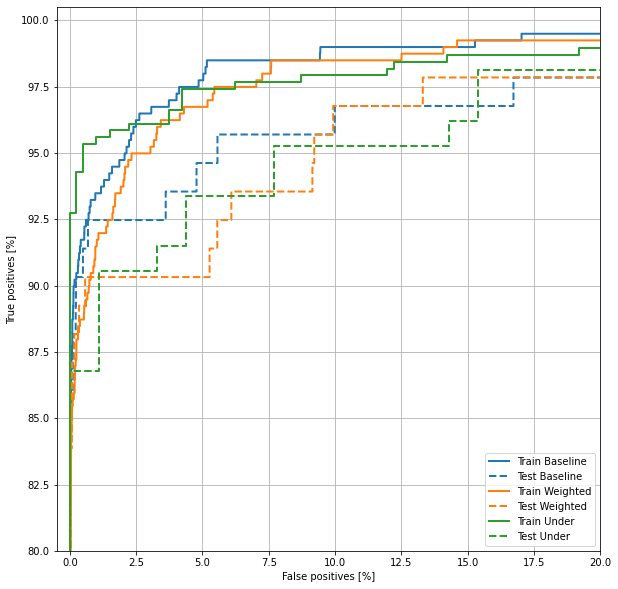

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Under", train_under_labels, train_predictions_under, color=colors[2])
plot_roc("Test Under", test_under_labels, test_predictions_under, color=colors[2], linestyle='--')

plt.legend(loc='lower right')